In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Input, Masking, Dense, RepeatVector, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
import pandas as pd

from collections import defaultdict

import matplotlib.ticker as ticker


/home/scicchitano/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scicchitano/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scicchitano/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scicchitano/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [2]:
fine_training_1 = 250  # 12.04.2016  --> 12.04.2016 00:00 anche inizio test_1
inizio_training_2 = 345 # 21.7.2016  --> 22.07.2016 00:00 anche la fine del test_1
fine_training_2 = 1200 # --> 18.11.2018 --> 18.11.2018 00:00 anche inizio test_2
fine_test_2 = 1300 # 26.2.2019 --> 27.02.2019 00:00

window_size_ = 50
window_shift_ = 1

def create_sequences(matrix, window_size, window_shift):
    n_seq = matrix.shape[0]
    n_feats = matrix.shape[1]

    start_indexes = range(0, n_seq - window_size + 1, window_shift)
    end_indexes = range(window_size, n_seq + 1, window_shift)

    tensor = [matrix[start_indexes[i]: end_indexes[i]] for i in range(len(start_indexes))]

    diff = n_seq - end_indexes[-1]

    if diff > 0:
        new_rows = np.zeros((window_size, n_feats))
        new_rows[0: n_seq - start_indexes[-1] - window_shift, :] = matrix[start_indexes[-1] + window_shift:, :]
        tensor.append(new_rows)

    return np.array(tensor)

def createSets():
    frame = pd.read_csv('FeaturesNormMobileFINALE.csv', low_memory=False)
    timestamp_list = frame['timestamp']
    dataframe = frame[['block_size_average','provided_gas_average','block_difficulty_average',
                                    'transactions_average_per_block',
                                    'gas_used_sum','transactions_number']]
    
    dataframe.columns = [''] * len(dataframe.columns)  #  elimino header del dataframe
    training_1 = dataframe[:fine_training_1]
    test_1 = dataframe[fine_training_1:inizio_training_2]
    training_2 = dataframe[inizio_training_2:fine_training_2]
    test_2 = dataframe[fine_training_2:fine_test_2]

    training_1 = np.array(training_1, dtype='float64')
    test_1 = np.array(test_1, dtype='float64')
    training_2 = np.array(training_2, dtype='float64')
    test_2 = np.array(test_2, dtype='float64')

    return training_1, test_1, training_2, test_2, dataframe, timestamp_list

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.title('Model Loss PostDAO-Pre2019 (normalized quantile mobile)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.savefig('plot/loss_PostDAO_Pre2019_norm_mobile_2')
    plt.show()

In [3]:
training_1, test_1, training_2, test_2, dataframe, timestamp_list = createSets()
print(test_1.shape)
training_1 = create_sequences(training_1,window_size_,window_shift_)
test_1 = create_sequences(test_1,window_size_,window_shift_)
training_2 = create_sequences(training_2,window_size_,window_shift_)
test_2 = create_sequences(test_2,window_size_,window_shift_)
print(test_1.shape)
training_set = np.concatenate((training_1,training_2), axis=0)

(95, 6)
(46, 50, 6)


In [7]:
seq_len = training_set.shape[1]
n_features = training_set.shape[2]
cells = 32

input_layer = Input((seq_len, n_features))
x = Masking()(input_layer)
x = LSTM(cells, activation='tanh')(x)
x = RepeatVector(seq_len)(x)
x = LSTM(cells, activation='tanh', return_sequences=True)(x)
output_layer = TimeDistributed(Dense(n_features))(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

model_path = 'saved_models/model_21_01_2020.h5'

mcp = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', period=2)
csv_logger = CSVLogger('log/log_21_01_2020.csv')
callbacks_list = [mcp,csv_logger]
history_ = model.fit(training_set, training_set, epochs = 500, batch_size = 50,
                     verbose=1, validation_split=0.2, callbacks= callbacks_list)



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 6)]           0         
_________________________________________________________________
masking_1 (Masking)          (None, 50, 6)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                4992      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 6)             198       
Total params: 13,510
Trainable params: 13,510
Non-trainable params: 0
_______________________________________________________

805/805 [==============================] - 2s 2ms/sample - loss: 0.2106 - val_loss: 0.7016
Epoch 68/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2092 - val_loss: 0.7094
Epoch 69/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2132 - val_loss: 0.7048
Epoch 70/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2114 - val_loss: 0.7042
Epoch 71/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2069 - val_loss: 0.7060
Epoch 72/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2056 - val_loss: 0.7089
Epoch 73/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2043 - val_loss: 0.7121
Epoch 74/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2060 - val_loss: 0.7105
Epoch 75/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2034 - val_loss: 0.7120
Epoch 76/500
805/805 [==============================] - 2s 2ms/sample - loss:

805/805 [==============================] - 2s 2ms/sample - loss: 0.1868 - val_loss: 0.7209
Epoch 146/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.2016 - val_loss: 0.7689
Epoch 147/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1973 - val_loss: 0.7597
Epoch 148/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1933 - val_loss: 0.7451
Epoch 149/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1901 - val_loss: 0.7466
Epoch 150/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1873 - val_loss: 0.7416
Epoch 151/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1850 - val_loss: 0.7467
Epoch 152/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1845 - val_loss: 0.7378
Epoch 153/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1842 - val_loss: 0.7422
Epoch 154/500
805/805 [==============================] - 2s 2ms/sampl

805/805 [==============================] - 2s 2ms/sample - loss: 0.1814 - val_loss: 0.7434
Epoch 224/500
805/805 [==============================] - 1s 2ms/sample - loss: 0.1735 - val_loss: 0.7372
Epoch 225/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1696 - val_loss: 0.7460
Epoch 226/500
805/805 [==============================] - 1s 2ms/sample - loss: 0.1725 - val_loss: 0.7278
Epoch 227/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1752 - val_loss: 0.7312
Epoch 228/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1729 - val_loss: 0.7363
Epoch 229/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1674 - val_loss: 0.7364
Epoch 230/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1666 - val_loss: 0.7380
Epoch 231/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1669 - val_loss: 0.7296
Epoch 232/500
805/805 [==============================] - 2s 2ms/sampl

805/805 [==============================] - 2s 2ms/sample - loss: 0.1694 - val_loss: 0.7301
Epoch 302/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1734 - val_loss: 0.7427
Epoch 303/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1603 - val_loss: 0.7379
Epoch 304/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1568 - val_loss: 0.7345
Epoch 305/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1546 - val_loss: 0.7387
Epoch 306/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1532 - val_loss: 0.7381
Epoch 307/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1543 - val_loss: 0.7372
Epoch 308/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1541 - val_loss: 0.7352
Epoch 309/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1552 - val_loss: 0.7404
Epoch 310/500
805/805 [==============================] - 2s 2ms/sampl

805/805 [==============================] - 2s 2ms/sample - loss: 0.1504 - val_loss: 0.7595
Epoch 380/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1701 - val_loss: 0.7814
Epoch 381/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1712 - val_loss: 0.7702
Epoch 382/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1677 - val_loss: 0.7600
Epoch 383/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1664 - val_loss: 0.7782
Epoch 384/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1524 - val_loss: 0.7652
Epoch 385/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1507 - val_loss: 0.7642
Epoch 386/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1514 - val_loss: 0.7639
Epoch 387/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1570 - val_loss: 0.7577
Epoch 388/500
805/805 [==============================] - 2s 2ms/sampl

805/805 [==============================] - 2s 2ms/sample - loss: 0.1441 - val_loss: 0.7827
Epoch 458/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1697 - val_loss: 0.7778
Epoch 459/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1637 - val_loss: 0.7740
Epoch 460/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1531 - val_loss: 0.7844
Epoch 461/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1536 - val_loss: 0.7603
Epoch 462/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1476 - val_loss: 0.7719
Epoch 463/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1493 - val_loss: 0.7765
Epoch 464/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1498 - val_loss: 0.7767
Epoch 465/500
805/805 [==============================] - 2s 2ms/sample - loss: 0.1795 - val_loss: 0.7687
Epoch 466/500
805/805 [==============================] - 2s 2ms/sampl

In [8]:
def sliding_average(predictions, window_shift, timestamps):
    sliding_avg = defaultdict(lambda: 0)
    count = defaultdict(lambda: 0)
    i = 0
    for index, line in enumerate(predictions):
        for pred in line:
            count[timestamps[i]] += 1
            sliding_avg[timestamps[i]] += pred
            i += 1
        i = i - len(line) + window_shift
    for timestamp in sliding_avg.keys():
        if sliding_avg[timestamp] > 0:
            sliding_avg[timestamp] = sliding_avg[timestamp] / count[timestamp]

    return sliding_avg

def plot_outlierness(outlierness):
    #sorted_dict = sorted(outlierness.items(), key=lambda kv: kv[1], reverse=True)
    #print(sorted_dict)
    #x = [p[0] for p in sorted_dict]
    #y = [p[1] for p in sorted_dict]
    

    lists = outlierness.items()  # sorted by key, return a list of tuples

    x, y = zip(*lists)  # unpack a list of pairs into two tuples
    
    fig, ax = plt.subplots(figsize=(60,50))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
    
    ax.tick_params(labelrotation=65)
    plt.plot(x,y, linewidth = 10)
    plt.xlabel('Timestamp', fontsize=120) 
    plt.ylabel('Score', fontsize=120)
    #plt.title('Outlierness score DAO Attack \n (training on D1) \n', fontsize=130)
    #plt.title('Outlierness score 51% Attack \n (training on D1) \n', fontsize=130)
    #plt.title('Outlierness score 51% Attack \n (training on D1 ∪ D2) \n', fontsize=130)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(100) # Size here overrides font_prop
    #ax.axvline(x=316, color='red', alpha=0.5, linewidth = 10)
    ax.axvline(x=1247, color='red', alpha=0.5, ls='dashed', linewidth = 10)
    ax.axvline(x=1250, color='red', alpha=0.5, ls='dashed', linewidth = 10)
    #plt.savefig('score_DAOattack_model_PREDAO_MOBILE.pdf')
    #plt.savefig('score_2019attack_model_PREDAO_MOBILE.pdf')
    #plt.savefig('score_2019attack_model_PREDAO_concat_PostDAO_Pre2019_MOBILE.pdf')
    plt.savefig('29_gen_2020_D1_U_D2_51.png')
    plt.show()

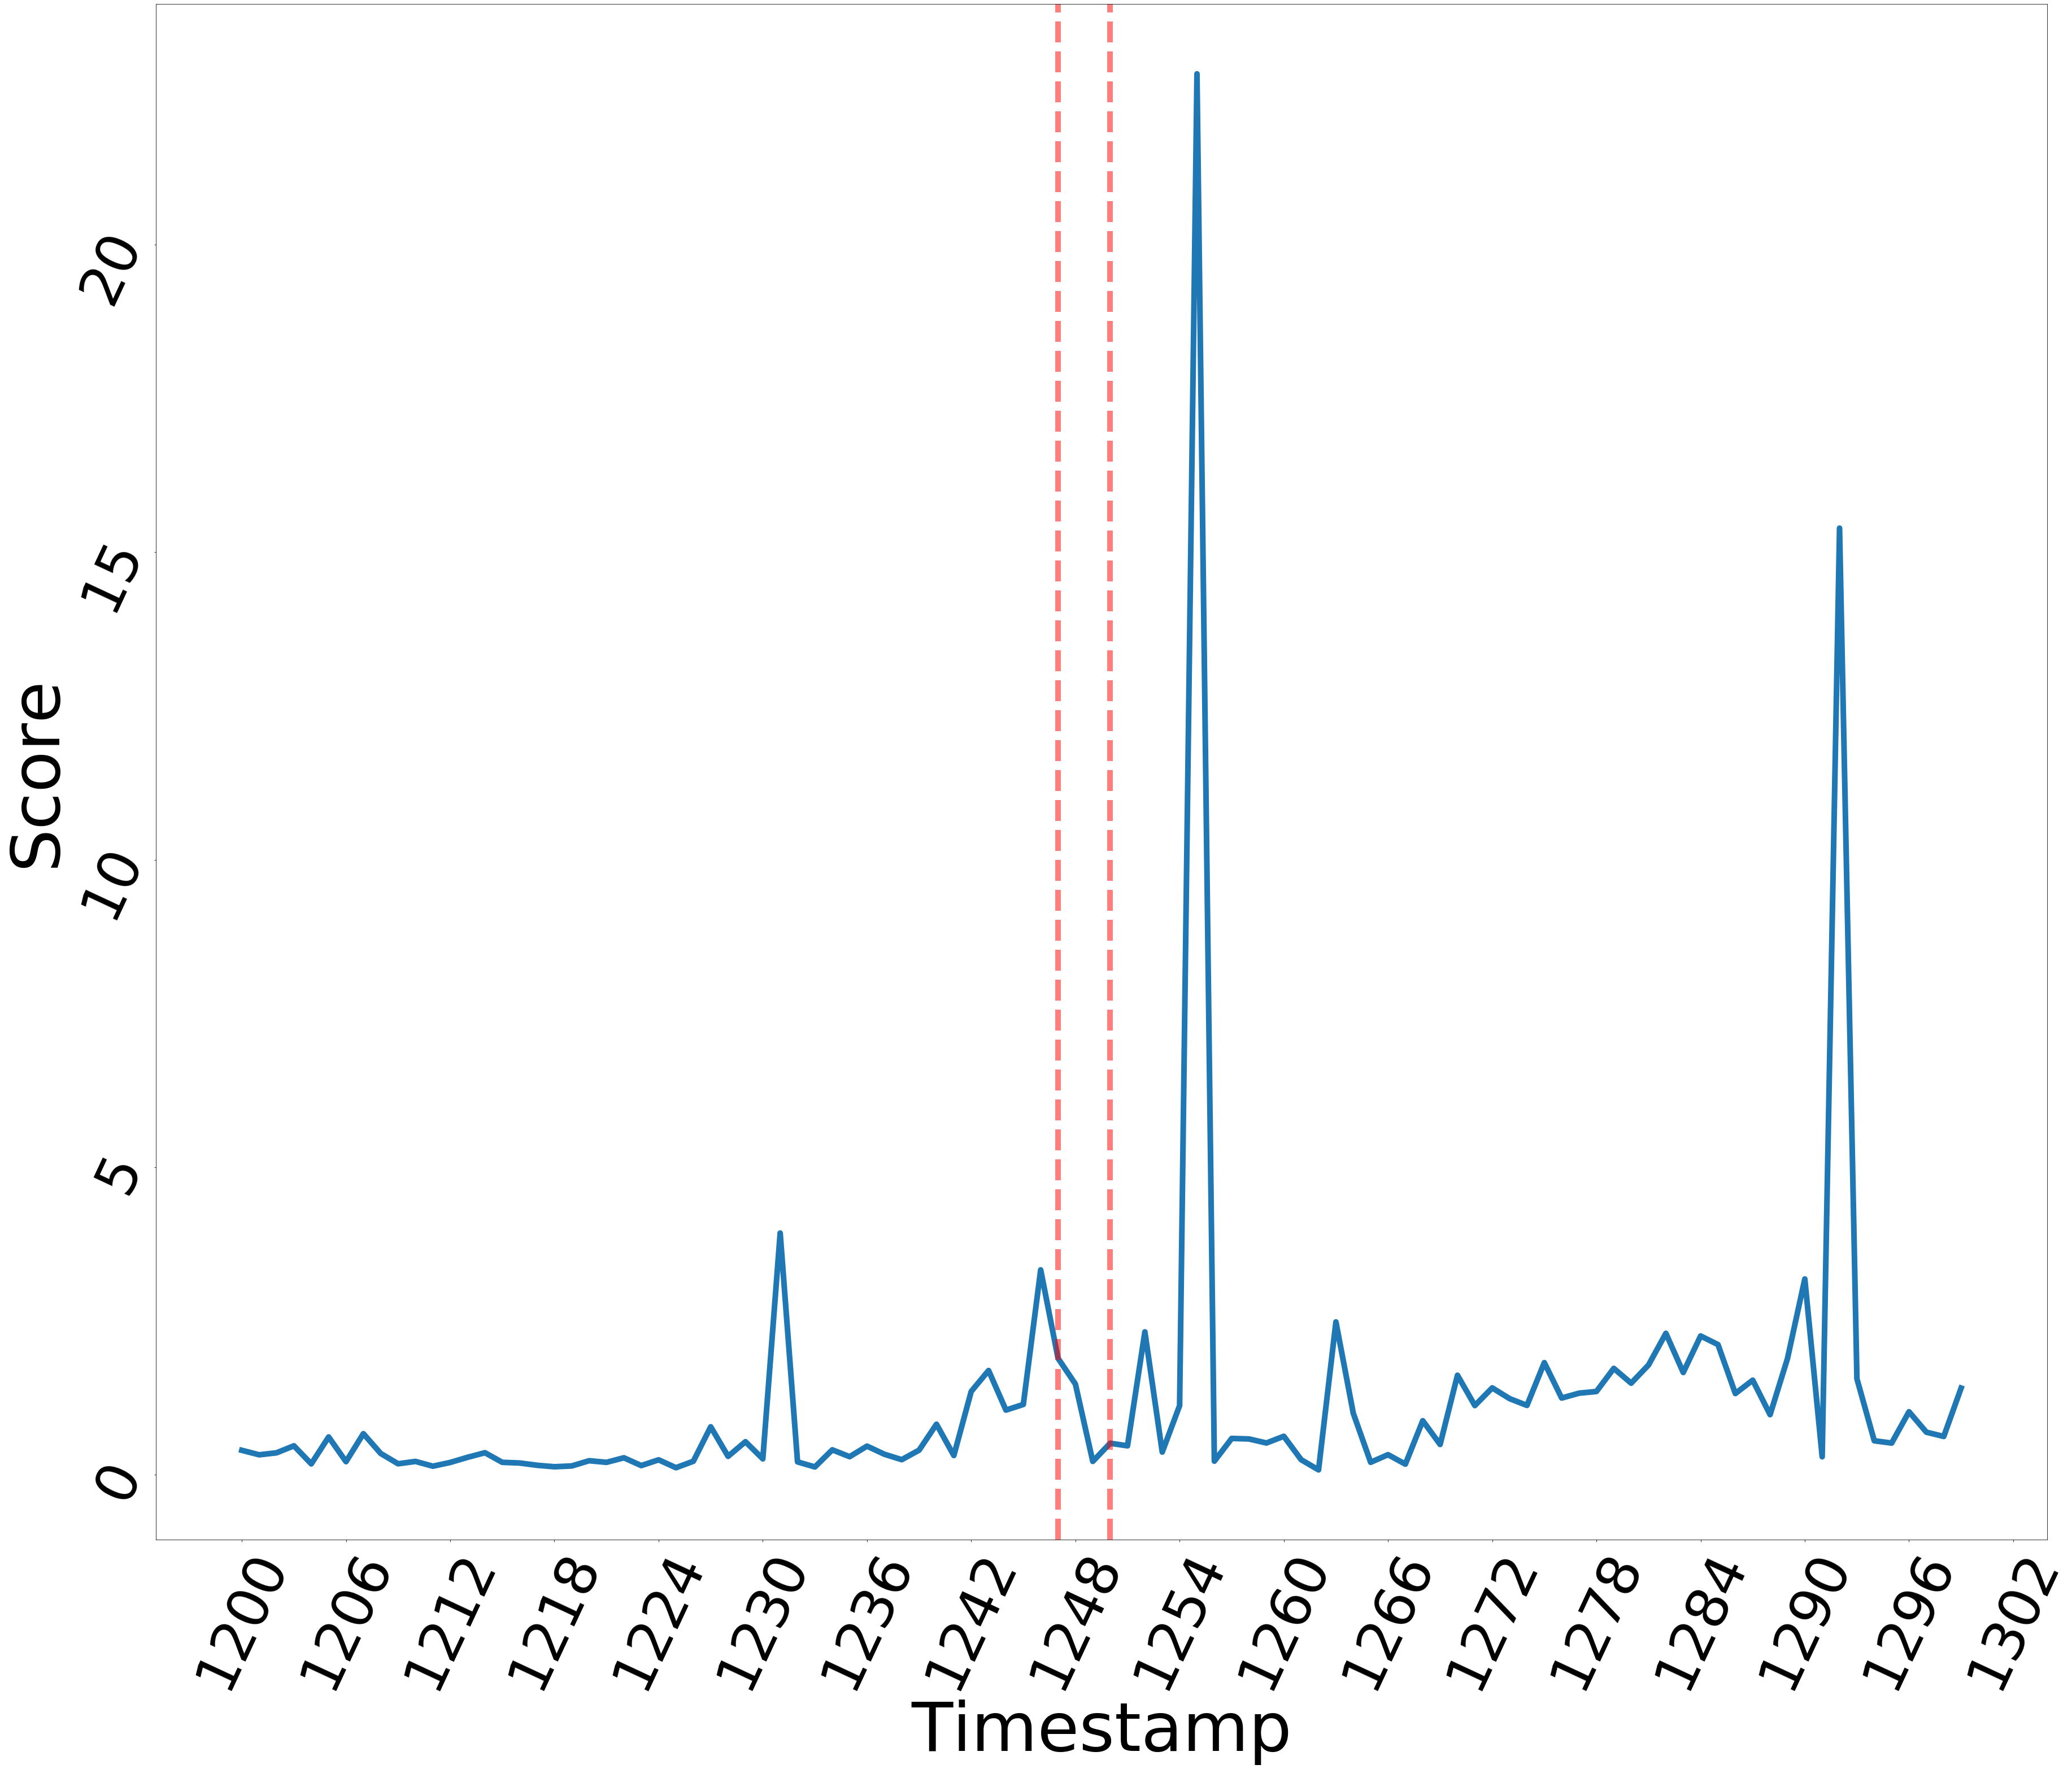

In [9]:
model_path = 'saved_models/model_21_01_2020.h5'
model = load_model(model_path)
#timestamp_test = list(range(250,345)) # --> DAO attack
timestamp_test = range(1200,1300)

#timestamp = timestamp_list[fine_training_2:fine_test_2].tolist()


prediction_test = model.predict(test_2)
x = np.sum(np.power(np.absolute(test_2 - prediction_test), 2), axis=2)

outlierness_ = sliding_average(
    np.sum(np.power(np.absolute(test_2 - prediction_test), 2), axis=2), window_shift_, timestamp_test)
plot_outlierness(outlierness_)